<a href="https://colab.research.google.com/github/strongeryoung/class_SmartDataAnalysis/blob/main/%EA%B4%80%EA%B4%91%EC%88%98%EC%A7%80_%EC%8B%9C%EA%B3%84%EC%97%B4_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
## SARIMAX
import os
os.chdir('/content/drive/MyDrive/Stock_Investment_Strategy/Function')

In [ ]:
pip install xmltodict

In [ ]:
import requests
import json
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from KEYS import *


# coding: utf-8
import requests 	  # API 요청할 때 쓰는 라이브러리
import xmltodict 	  # xml형태를 dictionary {'a':1,'b':23}
import json  # json을 쓰기위함
import os
import bs4

from datetime import *
from urllib.parse import urlencode, quote_plus, unquote

import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm


%matplotlib inline
from matplotlib import rcParams
from matplotlib import font_manager, rc
import matplotlib.dates as mdates
import seaborn as sns

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# [출처] [파이썬] colab에서 plt 한글깨짐 해결|작성자 서울시립대 통계학과

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔글꼴 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 12
# [출처] [파이썬] colab에서 plt 한글깨짐 해결|작성자 서울시립대 통계학과

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (22.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120899 files and direc

In [ ]:
def get_time_series_for_bok(y, m, d, adj_days):

    today = date.today()

    # 경제 데이터 발표 주기를 고려한 날짜 조정 : 1개월 빼기
    adj_dates = adj_days

    time_adj = today - timedelta(days=adj_dates)
    s_date = date(y, m, d)

    # 텍스트화된 날자 데이터 만들기
    date1 = s_date.strftime("%Y-%m-%d").replace('-', '')
    date2 = time_adj.strftime("%Y-%m-%d").replace('-', '')

    #date2 = str(date2)

    # 시작 날짜와 끝 날짜를 datetime 형태로 변환
    start_date = datetime.strptime(date1, "%Y%m%d")
    end_date = datetime.strptime(date2, "%Y%m%d")

    # date_range를 사용하여 time series 인덱스 생성
    time_index = pd.date_range(start=start_date, end=end_date, freq='M')

    n = len(time_index)

    start_dt = date1[:-2]
    end_dt = date2[:-2]

    return start_dt, end_dt, time_index, n


## 월간 경제 데이터 수신을 위한 API 함수 만들기

def get_m_econ_data(n, item_code1, item_code2, item_code3, date1, date2, inter):

    df_list = []

    print(item_code1, item_code2)

    key = KEYS['BOK']
    url =  f"http://ecos.bok.or.kr/api/StatisticSearch/{key}/json/kr/1/{n}/{item_code1}/{inter}/{date1}/{date2}/{item_code2}/{item_code3}"
    response = requests.get(url)
    #print(response.status_code)
    data = response.text
    data = json.loads(data)
    data_df = pd.DataFrame(data['StatisticSearch']['row'])
    #print(data_df)
    df_list.append(data_df)

    return df_list


def get_multi_econ_monthly_data(n, item_code1, item_code2, item_code3, s_date, e_date, inter):

    df_list = []

    date1 = s_date[:-2]
    date2 = e_date[:-2]

    for item in item_code2:

        temp_df = get_m_econ_data(n, item_code1, item, item_code3, s_date, e_date, inter)
        temp_df = temp_df[0]

        temp_df['DATA_VALUE'] = temp_df['DATA_VALUE'].astype('float64')
        temp_df['interval'] = 'M'
        temp_df = temp_df[['TIME', 'ITEM_NAME1', 'DATA_VALUE', 'interval']].copy()

        # 'TIME' 열을 날짜 형식으로 변환
        temp_df['TIME'] = pd.to_datetime(temp_df['TIME'], format='%Y%m')
        # 월말 기준으로 'TIME' 열을 변환
        temp_df['TIME'] = temp_df['TIME'] + pd.offsets.MonthEnd(0)
        temp_df = temp_df.set_index('TIME')
        temp_df.index.name = 'Date'
        df_list.append(temp_df)

    df = pd.concat(df_list)

    return df


def evaluation_tr(Y_real, Y_pred, graph_on=False):

    graph_on = True
    Y_real = Y_train_re
    Y_pred = pred_tr_sarimax

    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]

    Y_pred_df = pd.DataFrame(Y_pred )
    Y_pred_df.index = Y_real.index
    Y_pred_df.columns = ['prediction']

    if graph_on == True:
        df = pd.concat([Y_real, Y_pred_df], axis=1)
        df = df.iloc[13:]
        df.plot(kind='line', figsize=(20,6), xlim=(df.index[12:].min(), df.index[12:].max()), linewidth=3, fontsize=15)
        plt.title('Time Series of Data', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)

    MAE = abs(Y_real.iloc[13:].values.flatten() - Y_pred_df.iloc[13:].values.flatten()).mean()
    MSE = ((Y_real.iloc[13:].values.flatten() - Y_pred_df.iloc[13:].values.flatten())**2).mean()
    MAPE = (abs(Y_real.iloc[13:].values.flatten() - Y_pred_df.iloc[13:].values.flatten())/Y_real.iloc[13:].values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.iloc[13:].values.flatten() - Y_pred_df.iloc[13:].values.flatten(), index=Y_pred_df.index[13:], columns=['Error'])

    return Score, Residual


def evaluation_te(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]

    tem_df = pd.DataFrame(Y_pred )
    tem_df.index = Y_real.index
    tem_df.columns = ['prediction']

    if graph_on == True:
        pd.concat([Y_real, tem_df], axis=1).plot(kind='line', figsize=(20,6), xlim=(Y_real.index.min(),Y_real.index.max()), linewidth=3, fontsize=15)
        plt.title('Time Series of Data', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)

    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred.values.flatten(), index=Y_real.index, columns=['Error'])

    return Score, Residual


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation_tr(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation_te(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te


### Error analysis
def stationarity_adf_test(Y_Data, col_name):
    if len(col_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:2],
                                     index=['Statistics', 'p_value'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[col_name])[0:2],
                                     index=['Statistics', 'p_value'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[col_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[col_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])

    return Stationarity_adf

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):

    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', height=5.2, aspect=2, ci=99, sharey=True)

        # xticks와 yticks의 글자 크기 조절
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        # X, Y 레이블 폰트 크기 조절
        plt.xlabel('Time', fontsize=14)  # X 레이블 폰트 크기 조절
        plt.ylabel('Error', fontsize=14)  # Y 레이블 폰트 크기 조절

        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)
        # xticks와 yticks의 글자 크기 조절
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        # X, Y 레이블 폰트 크기 조절
        plt.xlabel('Error', fontsize=14)  # X 레이블 폰트 크기 조절
        plt.ylabel('Density', fontsize=14)  # Y 레이블 폰트 크기 조절

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=30, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=30, use_vlines=True, ax=axes[1])

        # xticks와 yticks의 글자 크기 조절
        axes[0].tick_params(axis='both', which='major', labelsize=12)
        axes[1].tick_params(axis='both', which='major', labelsize=12)

        # x축 레이블 및 y축 레이블의 제목 글자 크기 조절
        axes[0].set_xlabel('Lags', fontsize=12)
        axes[0].set_ylabel('ACF', fontsize=12)
        axes[1].set_xlabel('Lags', fontsize=12)
        axes[1].set_ylabel('PACF', fontsize=12)

        #타이틀 폰트 크기 조절
        axes[0].set_title('ACF Plot', fontsize=12)
        axes[1].set_title('PACF Plot', fontsize=12)
        # 서브플롯 간격 조절
        plt.subplots_adjust(hspace=1.0)  # 수직 간격 조절

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                              index=['Normality'], columns=['Statistics', 'p_value']).T

    # # Checking for Autocorrelation
    # # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,20,30])['lb_stat'], columns=['Test Statistics']),
                                  pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,20,30])['lb_pvalue'], columns=['p_value'])], axis=1).T

    Autocorrelation = sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,20,30])
    Autocorrelation.columns = ['Statistics', 'p_value']
    Autocorrelation_T = Autocorrelation.T
    Autocorrelation_T.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag20)', 'Autocorr(lag30)']

    # # # Checking Heteroscedasticity
    # # # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Statistics', 'p_value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Normality, Autocorrelation_T, Heteroscedasticity], join='outer', axis=1)

    return Score.round(3)

In [ ]:
start_dt, end_dt, tm_index, n = get_time_series_for_bok(1990, 1, 1, 30)
inter = 'M'

item_code1 = '301Y013'
item_code2 = ['2C1Y00', '2C2Y00']
item_code3 = ''

data = get_multi_econ_monthly_data(n, item_code1, item_code2, item_code3, start_dt, end_dt, inter)
data

301Y013 2C1Y00
301Y013 2C2Y00


,ITEM_NAME1,DATA_VALUE,interval
Date,,,
1990-01-31,일반여행수입,265.6,M
1990-02-28,일반여행수입,233.2,M
1990-03-31,일반여행수입,245.7,M
1990-04-30,일반여행수입,257.3,M
1990-05-31,일반여행수입,284.4,M
...,...,...,...
2023-06-30,일반여행지급,2250.2,M
2023-07-31,일반여행지급,2271.0,M
2023-08-31,일반여행지급,2092.7,M


<Axes: xlabel='Date'>

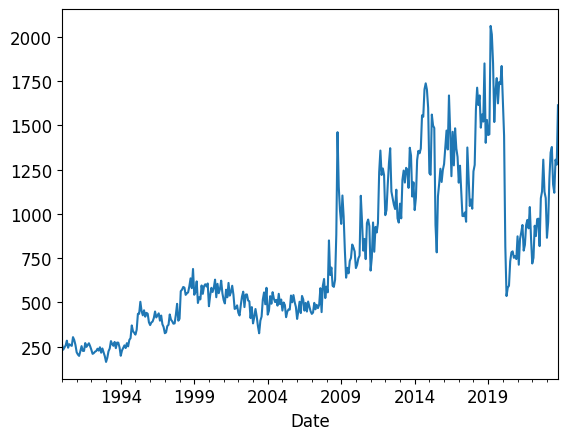

In [ ]:
data.columns= ['항목', '여행수지', '주기']

data_re = data.reset_index()

pivot_data = data_re.pivot(index='Date', columns='항목', values='여행수지')

pivot_data['일반여행수입'].plot()

<Axes: xlabel='Date'>

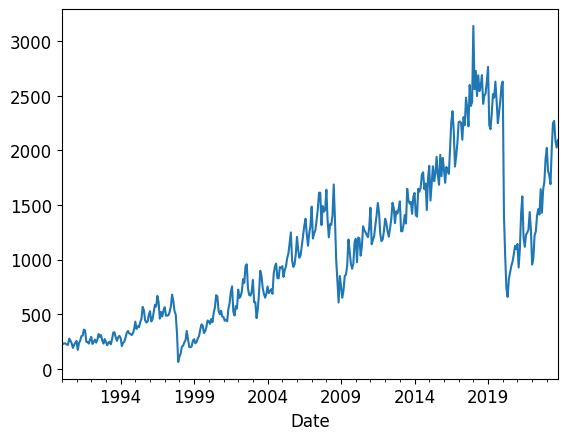

In [ ]:
pivot_data['일반여행지급'].plot()

In [ ]:
pivot_data[['여행수입_변화율', '여행지급_변화율']] = pivot_data[['일반여행수입', '일반여행지급']].pct_change()

In [ ]:
pivot_data[['여행수입_log', '여행지급_log']] = np.log(pivot_data[['일반여행수입', '일반여행지급']])

In [ ]:
pivot_data

항목,일반여행수입,일반여행지급,여행수입_변화율,여행지급_변화율,여행수입_log,여행지급_log
Date,,,,,,
1990-01-31,265.6,226.9,NaN,NaN,5.581991,5.424509
1990-02-28,233.2,225.6,-0.121988,-0.005729,5.451896,5.418764
1990-03-31,245.7,233.6,0.053602,0.035461,5.504111,5.453610
1990-04-30,257.3,230.3,0.047212,-0.014127,5.550243,5.439383
1990-05-31,284.4,221.2,0.105325,-0.039514,5.650382,5.399067
...,...,...,...,...,...,...
2023-05-31,1378.3,2008.4,0.023085,0.187489,7.228606,7.605094
2023-06-30,1167.0,2250.2,-0.153305,0.120394,7.062192,7.718774
2023-07-31,1119.8,2271.0,-0.040446,0.009244,7.020905,7.727976


In [ ]:
df_drop = pivot_data.dropna()
change_df = df_drop[['여행수입_변화율', '여행지급_변화율']]
change_df.corr()

항목,여행수입_변화율,여행지급_변화율
항목,,
여행수입_변화율,1.000000,0.019865
여행지급_변화율,0.019865,1.000000


,Stationarity_adf
Statistics,-1.426506
p_value,0.569505
Critical Value(1%),-3.447142
Maximum Information Criteria,4908.073654


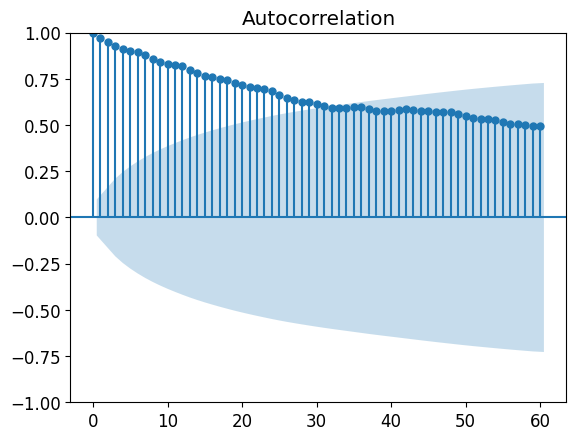

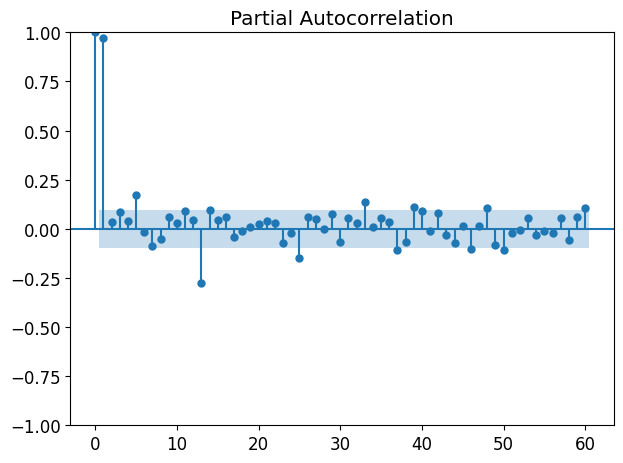

In [ ]:
## 정상성 테스트

test_data = pivot_data[['일반여행지급']].copy()
display(stationarity_adf_test(test_data.values.flatten(), []))
sm.graphics.tsa.plot_acf(test_data, lags=60, use_vlines=True)
sm.graphics.tsa.plot_pacf(test_data, lags=60, use_vlines=True)
plt.tight_layout()
plt.show()

,Stationarity_adf
Statistics,-1.520349
p_value,0.523422
Critical Value(1%),-3.447099
Maximum Information Criteria,-485.390824


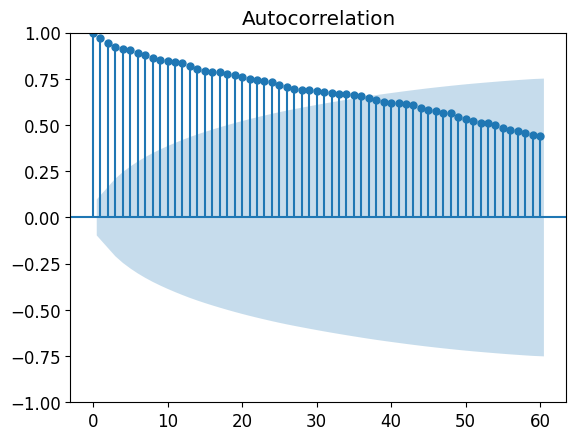

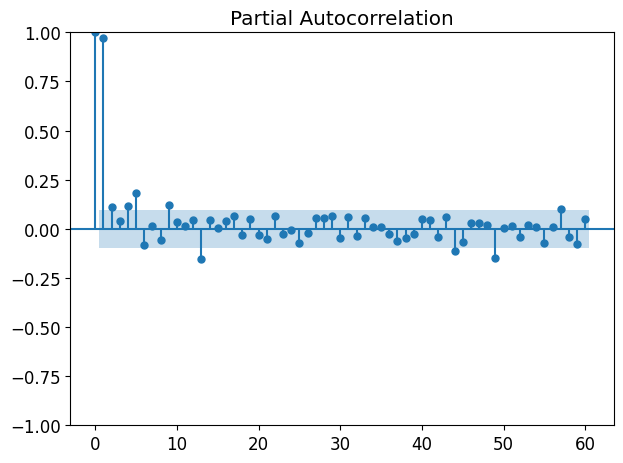

In [ ]:
## 정상성 테스트 log

test_data = pivot_data[['여행수입_log']].copy()
display(stationarity_adf_test(test_data.values.flatten(), []))
sm.graphics.tsa.plot_acf(test_data, lags=60, use_vlines=True)
sm.graphics.tsa.plot_pacf(test_data, lags=60, use_vlines=True)
plt.tight_layout()
plt.show()

In [ ]:
tourism_balance_log = pivot_data[['여행수입_log', '여행지급_log']]

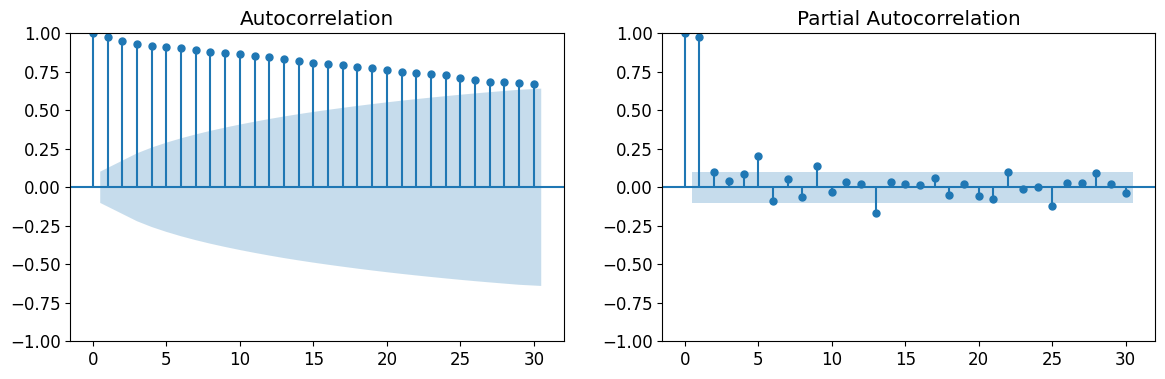

In [ ]:
## 최종 타겟 선정 및 Train/Test 데이터 분리
target_df = tourism_balance_log[['여행수입_log']].copy()
split_dt = '2021-01-01'
Y_train = target_df[target_df.index < split_dt]
Y_test = target_df[target_df.index >= split_dt]

plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(Y_train, lags=30, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(Y_train, lags=30, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.show()

In [ ]:
from itertools import product
from tqdm.notebook import tqdm

In [ ]:
Y_train = Y_train

## Parameter Setting
p, q = range(0,3), range(0,3)
d = range(1,2)
P, Q = range(0,3), range(0,3)
D = range(0,2)
m = 12
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(product(P, D, Q))]

## SARIMAX
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result =sm.tsa.SARIMAX(Y_train, trend='c',
                                   order=trend_param, seasonal_order=seasonal_params).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0], SARIMAX_order[AIC.index(min(AIC))][1]))

  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 0, 0, 12) AIC=-443.4277764299088, BIC=-435.59537230469397


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 0, 1, 12) AIC=-456.5726393659303, BIC=-444.824033178108


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 0, 2, 12) AIC=-461.2779805252304, BIC=-445.61317227480066


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 1, 0, 12) AIC=-283.60230849243953, BIC=-275.835663715463


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 1, 1, 12) AIC=-470.87383323087886, BIC=-459.22386606541403


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(0, 1, 2, 12) AIC=-468.88835419916404, BIC=-453.3550646452109


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 0, 0, 12) AIC=-461.21345440694097, BIC=-449.46484821911866


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 0, 1, 12) AIC=-500.41846920503804, BIC=-484.7536609546083


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 0, 2, 12) AIC=-498.2528018378513, BIC=-478.6717915248141
Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 1, 0, 12) AIC=-363.6914499311104, BIC=-352.0414827656456


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 1, 1, 12) AIC=-468.8855054082693, BIC=-453.35221585431617


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(1, 1, 2, 12) AIC=-467.0726665070834, BIC=-447.656054564642


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 0, 0, 12) AIC=-467.1552027083354, BIC=-451.49039445790567


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 0, 1, 12) AIC=-498.41704491545687, BIC=-478.8360346024197


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 0, 2, 12) AIC=-496.5068080658765, BIC=-473.0095956902319


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 1, 0, 12) AIC=-394.76757926469077, BIC=-379.23428971073764


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 1, 1, 12) AIC=-467.23192638787407, BIC=-447.8153144454327


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 0) seasonal_order=(2, 1, 2, 12) AIC=-465.0524172933324, BIC=-441.7524829624027


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 0, 0, 12) AIC=-449.8955527984755, BIC=-438.1469466106532


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 0, 1, 12) AIC=-460.5811622940309, BIC=-444.91635404360113


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 0, 2, 12) AIC=-464.0454038754875, BIC=-444.46439356245037


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 1, 0, 12) AIC=-284.87761900165435, BIC=-273.2276518361895


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 1, 1, 12) AIC=-471.5562278922393, BIC=-456.02293833828617


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(0, 1, 2, 12) AIC=-469.54718877000585, BIC=-450.1305768275645


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 0, 0, 12) AIC=-464.33735123475446, BIC=-448.6725429843247


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 0, 1, 12) AIC=-501.80103669514267, BIC=-482.2200263821055


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 0, 2, 12) AIC=-498.0503022108739, BIC=-474.5530898352293
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 1, 0, 12) AIC=-365.1956738594496, BIC=-349.66238430549646


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 1, 1, 12) AIC=-469.5537476103496, BIC=-450.1371356679082
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(1, 1, 2, 12) AIC=-467.62021008678687, BIC=-444.3202757558572


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 0, 0, 12) AIC=-469.7751185141859, BIC=-450.19410820114877


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 0, 1, 12) AIC=-499.4121202928568, BIC=-475.9149079172122
Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 0, 2, 12) AIC=-497.72733932373745, BIC=-470.3139248854854


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 1, 0, 12) AIC=-399.91790360815264, BIC=-380.5012916657113


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 1, 1, 12) AIC=-467.9380523366214, BIC=-444.63811800569175


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 1) seasonal_order=(2, 1, 2, 12) AIC=-465.5498857874071, BIC=-438.36662906798915


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 0, 0, 12) AIC=-451.80124549515193, BIC=-436.1364372447222


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 0, 1, 12) AIC=-461.43055491435774, BIC=-441.8495446013206


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 0, 2, 12) AIC=-464.25785301013, BIC=-440.7606406344854


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 1, 0, 12) AIC=-284.50365287204727, BIC=-268.97036331809414


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 1, 1, 12) AIC=-472.71349817179686, BIC=-453.29688622935544


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(0, 1, 2, 12) AIC=-470.6607626424729, BIC=-447.36082831154323


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 0, 0, 12) AIC=-464.76182570780645, BIC=-445.1808153947693


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 0, 1, 12) AIC=-502.4005248459317, BIC=-478.9033124702871


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 0, 2, 12) AIC=-497.91599581510656, BIC=-470.5025813768545


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 1, 0, 12) AIC=-364.6833363860659, BIC=-345.2667244436245


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 1, 1, 12) AIC=-470.4375452717376, BIC=-447.1376109408079


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(1, 1, 2, 12) AIC=-468.7485457094799, BIC=-441.56528899006196


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 0, 0, 12) AIC=-469.7600387922317, BIC=-446.2628264165871


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 0, 1, 12) AIC=-498.5447213375902, BIC=-471.13130689933814


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 0, 2, 12) AIC=-497.3290494386864, BIC=-465.99943293782695


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 1, 0, 12) AIC=-400.63352850995057, BIC=-377.3335941790209


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 1, 1, 12) AIC=-469.21752079206976, BIC=-442.0342640726518


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(0, 1, 2) seasonal_order=(2, 1, 2, 12) AIC=-466.70219214317706, BIC=-435.6356130352708
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 0, 0, 12) AIC=-448.7069731670123, BIC=-436.95836697919


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 0, 1, 12) AIC=-459.843874056072, BIC=-444.17906580564227


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 0, 2, 12) AIC=-463.5119696070085, BIC=-443.93095929397134


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 1, 0, 12) AIC=-284.52727007134763, BIC=-272.8773029058828


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 1, 1, 12) AIC=-471.1461453846289, BIC=-455.61285583067576


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(0, 1, 2, 12) AIC=-469.1428079043693, BIC=-449.72619596192794


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 0, 0, 12) AIC=-463.74472522535103, BIC=-448.0799169749213


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 0, 1, 12) AIC=-501.2515451688878, BIC=-481.67053485585063


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 0, 2, 12) AIC=-499.08072470576485, BIC=-475.58351233012024


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 1, 0, 12) AIC=-364.8152539328113, BIC=-349.28196437885816


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 1, 1, 12) AIC=-469.14588689997333, BIC=-449.72927495753197


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(1, 1, 2, 12) AIC=-467.2208071594628, BIC=-443.92087282853316


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 0, 0, 12) AIC=-469.2663392698189, BIC=-449.68532895678175


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 0, 1, 12) AIC=-499.21818403141253, BIC=-475.7209716557679


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 0, 2, 12) AIC=-496.93994378247686, BIC=-469.5265293442248
Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 1, 0, 12) AIC=-398.80862923670867, BIC=-379.39201729426725


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 1, 1, 12) AIC=-467.50166540626435, BIC=-444.2017310753347


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 0) seasonal_order=(2, 1, 2, 12) AIC=-465.23803767458634, BIC=-438.0547809551684


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 0, 0, 12) AIC=-460.63422153639647, BIC=-444.9694132859667


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 0, 1, 12) AIC=-471.5789410685173, BIC=-451.9979307554801


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 0, 2, 12) AIC=-474.62296410696763, BIC=-451.125751731323


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 1, 0, 12) AIC=-302.56043507514687, BIC=-287.02714552119375
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 1, 1, 12) AIC=-476.43151761738113, BIC=-457.01490567493977


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(0, 1, 2, 12) AIC=-469.84901929810565, BIC=-446.549084967176


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 0, 0, 12) AIC=-475.4682124843714, BIC=-455.88720217133425


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 0, 1, 12) AIC=-508.8151528405299, BIC=-485.3179404648853


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 0, 2, 12) AIC=-502.5809071185636, BIC=-475.1674926803115


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 1, 0, 12) AIC=-374.4289023214628, BIC=-355.01229037902135


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 1, 1, 12) AIC=-474.22986186106914, BIC=-450.9299275301395


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(1, 1, 2, 12) AIC=-474.8814359683615, BIC=-447.6981792489435


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 0, 0, 12) AIC=-480.5864181204593, BIC=-457.0892057448147
Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 0, 1, 12) AIC=-503.28699516973006, BIC=-475.873580731478


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 0, 2, 12) AIC=-501.96070968074275, BIC=-470.6310931798833


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 1, 0, 12) AIC=-407.0158509288261, BIC=-383.71591659789647


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 1, 1, 12) AIC=-456.1453859279485, BIC=-428.96212920853054


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 1) seasonal_order=(2, 1, 2, 12) AIC=-471.6189688202833, BIC=-440.5523897123771


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 0, 0, 12) AIC=-458.8446792365546, BIC=-439.26366892351746


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 0, 1, 12) AIC=-469.8452798743559, BIC=-446.3480674987113


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 0, 2, 12) AIC=-473.30483421509564, BIC=-445.8914197768436


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 1, 0, 12) AIC=-300.570494796278, BIC=-281.15388285383665


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 1, 1, 12) AIC=-476.56828107205854, BIC=-453.2683467411289


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(0, 1, 2, 12) AIC=-474.03353531931725, BIC=-446.8502785998993


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 0, 0, 12) AIC=-473.83558297944194, BIC=-450.33837060379733


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 0, 1, 12) AIC=-504.0815351942156, BIC=-476.6681207559635


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 0, 2, 12) AIC=-493.81820314549543, BIC=-462.488586644636


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 1, 0, 12) AIC=-374.9578229090007, BIC=-351.65788857807104


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 1, 1, 12) AIC=-469.53838234698156, BIC=-442.3551256275636


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(1, 1, 2, 12) AIC=-472.5969606803095, BIC=-441.53038157240326


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 0, 0, 12) AIC=-478.47675868680585, BIC=-451.0633442485538
Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 0, 1, 12) AIC=-501.68434388125, BIC=-470.35472738039056


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 0, 2, 12) AIC=-497.9834187135589, BIC=-462.73760015009196


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 1, 0, 12) AIC=-406.14120139581263, BIC=-378.9579446763947


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 1, 1, 12) AIC=-473.28989527590306, BIC=-442.2233161679968


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(1, 1, 2) seasonal_order=(2, 1, 2, 12) AIC=-468.90412501163405, BIC=-433.95422351523956
Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 0, 0, 12) AIC=-448.0081579737398, BIC=-432.34334972331004


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 0, 1, 12) AIC=-458.7927097594553, BIC=-439.21169944641815


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 0, 2, 12) AIC=-462.3494644838507, BIC=-438.8522521082061


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 1, 0, 12) AIC=-283.2908534574664, BIC=-267.7575639035133


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 1, 1, 12) AIC=-471.08152320013244, BIC=-451.6649112576911


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(0, 1, 2, 12) AIC=-469.09575351430857, BIC=-445.7958191833789


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(1, 0, 0, 12) AIC=-462.60050312602397, BIC=-443.0194928129868


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(1, 0, 1, 12) AIC=-499.3522140101401, BIC=-475.85500163449547


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(1, 0, 2, 12) AIC=-495.3081828286887, BIC=-467.89476839043664


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(1, 1, 0, 12) AIC=-363.9140775662911, BIC=-344.49746562384973


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(1, 1, 1, 12) AIC=-469.07683033590024, BIC=-445.7768960049706


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(1, 1, 2, 12) AIC=-467.1185318845509, BIC=-439.93527516513296


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(2, 0, 0, 12) AIC=-468.18534254737625, BIC=-444.68813017173164


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(2, 0, 1, 12) AIC=-497.4027214741576, BIC=-469.98930703590554


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(2, 0, 2, 12) AIC=-496.78877683789517, BIC=-465.4591603370357


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(2, 1, 0, 12) AIC=-399.1405780959866, BIC=-375.84064376505694


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(2, 1, 1, 12) AIC=-467.50316907834303, BIC=-440.3199123589251


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 0) seasonal_order=(2, 1, 2, 12) AIC=-465.06392215033446, BIC=-433.9973430424282


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 0, 0, 12) AIC=-458.8765079600343, BIC=-439.29549764699715


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 0, 1, 12) AIC=-469.91719608952405, BIC=-446.41998371387945


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 0, 2, 12) AIC=-471.98310704729414, BIC=-444.5696926090421


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 1, 0, 12) AIC=-300.57470859324656, BIC=-281.1580966508052
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 1, 1, 12) AIC=-476.99126812818156, BIC=-453.6913337972519


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(0, 1, 2, 12) AIC=-474.68573814496494, BIC=-447.502481425547


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 0, 0, 12) AIC=-471.60580232366954, BIC=-448.1085899480249
Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 0, 1, 12) AIC=-507.5688488652597, BIC=-480.15543442700766


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 0, 2, 12) AIC=-494.9137010005044, BIC=-463.5840844996449


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 1, 0, 12) AIC=-374.8576406651683, BIC=-351.5577063342386


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 1, 1, 12) AIC=-467.9433230477323, BIC=-440.76006632831434


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(1, 1, 2, 12) AIC=-472.9200146763482, BIC=-441.85343556844197


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 0, 0, 12) AIC=-475.60015293957133, BIC=-448.18673850131927


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 0, 1, 12) AIC=-493.624998879159, BIC=-462.29538237829956


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 0, 2, 12) AIC=-492.0375838748292, BIC=-456.79176531136227


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 1, 0, 12) AIC=-404.2747219361079, BIC=-377.0914652166899


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 1, 1, 12) AIC=-467.35776998161117, BIC=-436.2911908737049


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

Fit SARIMAX: trend_order=(2, 1, 1) seasonal_order=(2, 1, 2, 12) AIC=-463.6443745931836, BIC=-428.6944730967891


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 0, 0, 12) AIC=-459.7072798064719, BIC=-436.2100674308273


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 0, 1, 12) AIC=-470.72875178393616, BIC=-443.3153373456841


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 0, 2, 12) AIC=-474.0778137863151, BIC=-442.74819728545566


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  

Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 1, 0, 12) AIC=-314.84802180234, BIC=-291.5480874714103


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 1, 1, 12) AIC=-474.8428124738982, BIC=-447.65955575448027


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(0, 1, 2, 12) AIC=-471.5431509559542, BIC=-440.47657184804797


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 0, 0, 12) AIC=-475.17340776355485, BIC=-447.7599933253028


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 0, 1, 12) AIC=-500.3911350796162, BIC=-469.06151857875676


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 0, 2, 12) AIC=-502.91791699983037, BIC=-467.67209843636346


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 1, 0, 12) AIC=-378.736092486816, BIC=-351.55283576739805


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 1, 1, 12) AIC=-471.0045015059883, BIC=-439.93792239808204


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(1, 1, 2, 12) AIC=-470.8342909854455, BIC=-435.884389489051


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 0, 0, 12) AIC=-480.72083689191004, BIC=-449.3912203910506


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 0, 1, 12) AIC=-495.84488396643474, BIC=-460.5990654029678


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 0, 2, 12) AIC=-498.94511656338784, BIC=-459.7830959373135


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 1, 0, 12) AIC=-404.7533150442903, BIC=-373.686735936384


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 1, 1, 12) AIC=-471.26927757687963, BIC=-436.31937608048514


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit SARIMAX: trend_order=(2, 1, 2) seasonal_order=(2, 1, 2, 12) AIC=-469.0304025317301, BIC=-430.1971786468473
The smallest AIC is -508.8151528405299 for model SARIMAX(1, 1, 1)x(1, 0, 1, 12)


In [ ]:
# 리스트를 데이터프레임으로 변환
order_df = pd.DataFrame(SARIMAX_order, columns=['(p, d, q)', '(P, D, Q, M)'])
# (p, d, q) 컬럼을 나누어 각각의 컬럼으로 만들기
order_df[['p', 'd', 'q']] = pd.DataFrame(order_df['(p, d, q)'].tolist(), index=order_df.index)
order_df[['P', 'D', 'Q', 'M']] = pd.DataFrame(order_df['(P, D, Q, M)'].tolist(), index=order_df.index)

# 불필요한 열 제거
order_df = order_df.drop(['(p, d, q)', '(P, D, Q, M)'], axis=1)
order_df.head(5)

AIC_df = pd.DataFrame(AIC, columns= ['AIC'])

Sarima_AIC = pd.concat([order_df, AIC_df], axis=1).sort_values(by='AIC', ascending=True)
Sarima_AIC.head(3)

,p,d,q,P,D,Q,M,AIC
79,1,1,1,1,0,1,12,-508.815153
133,2,1,1,1,0,1,12,-507.568849
97,1,1,2,1,0,1,12,-504.081535


In [ ]:
# 모델링
# 0	1	2	1	0	2	12
seasonal_order = 12

## SARIMAX
logarithm, differencing = True, False

fit_ts_sarimax = sm.tsa.SARIMAX(Y_train, order=(1,1,1), seasonal_order=(1,1,1,seasonal_order), trend='c').fit()
display(fit_ts_sarimax.summary())
pred_train_sarimax = fit_ts_sarimax.predict()
pred_test_sarimax = fit_ts_sarimax.get_forecast(len(Y_test)).predicted_mean
pred_test_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test)).conf_int()

# ## 비정상성으로 변환
if logarithm:
    Y_train_re = np.exp(Y_train).copy()
    Y_test_re = np.exp(Y_test).copy()
    pred_tr_sarimax = np.exp(pred_train_sarimax).copy()
    pred_te_sarimax = np.exp(pred_test_sarimax).copy()
    pred_te_sarimax_ci = np.exp(pred_test_sarimax_ci).copy()

if differencing:
    pred_tr_sarimax = np.cumsum(pred_train_sarimax).copy()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           여행수입_log   No. Observations:                  372
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 243.115
Date:                            Sat, 09 Dec 2023   AIC                           -474.230
Time:                                    04:57:40   BIC                           -450.930
Sample:                                01-31-1990   HQIC                          -464.964
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.459e-05   7.64e-05     -0.846      0.398      -0.000    8.51e-05
ar.L1          0.7804      0.061     12.793      0.000       0.661       0.900
ma.L1         -0.9266      0.043    -21.436      0.000      -1.011      -0.842
ar.S.L12      -0.0101      0.067     -0.152      0.879      -0.140       0.120
ma.S.L12      -0.9297      0.054    -17.076      0.000      -1.036      -0.823
sigma2         0.0141      0.001     15.884      0.000       0.012       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               357.18
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.56   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,MAE,MSE,MAPE
Train,69.156652,12817.972669,8.736310
Test,166.832185,54540.812456,14.401802


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


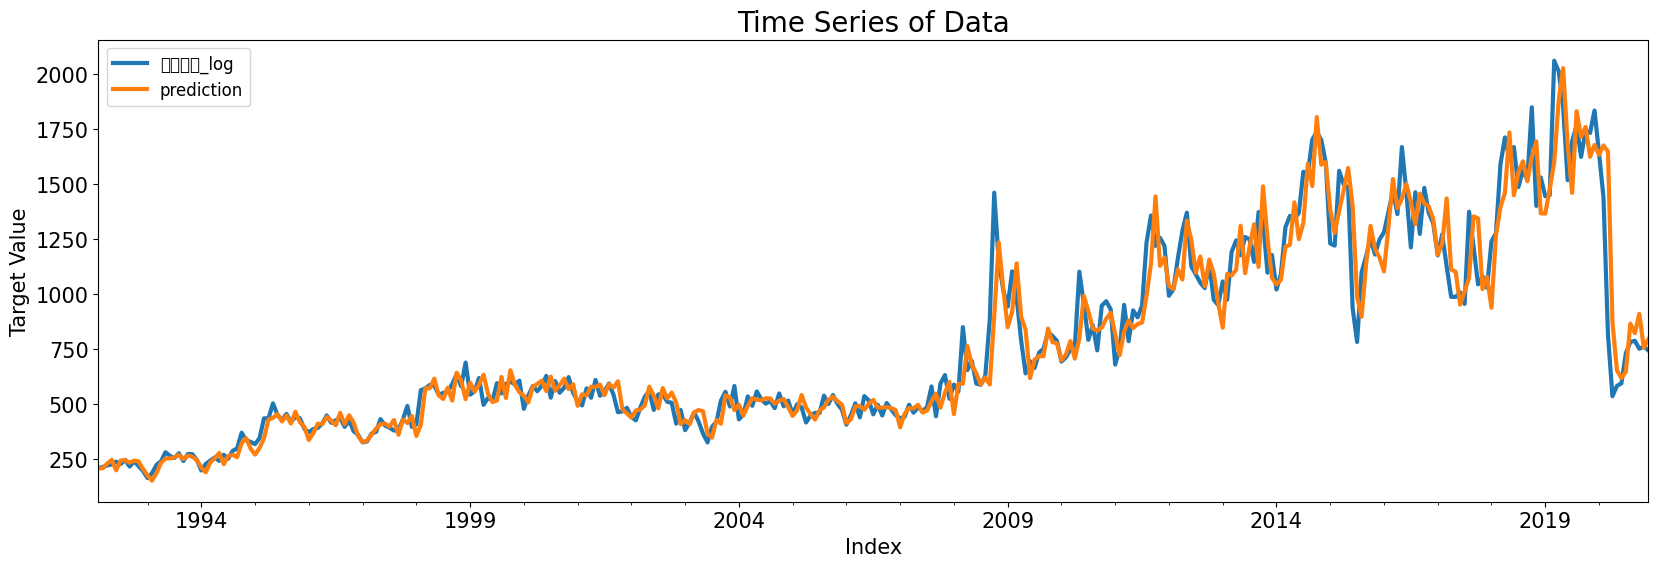

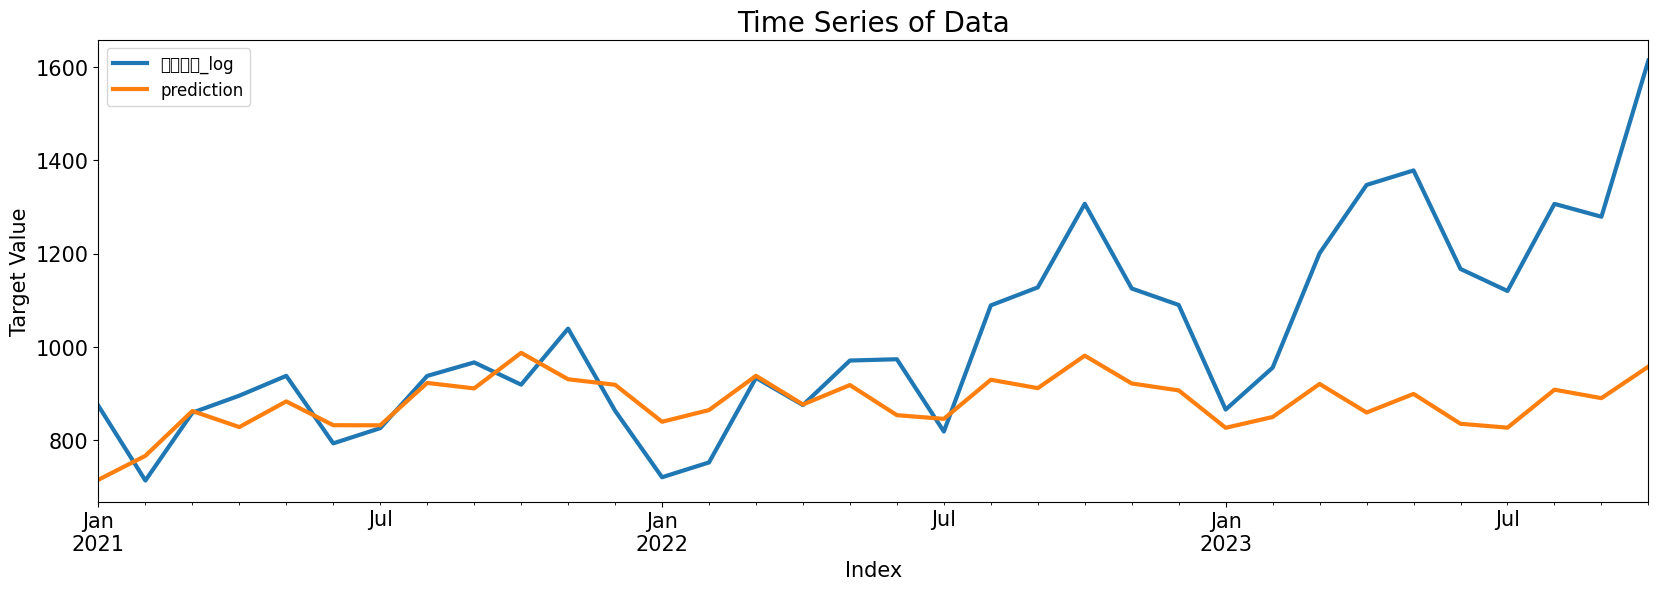

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


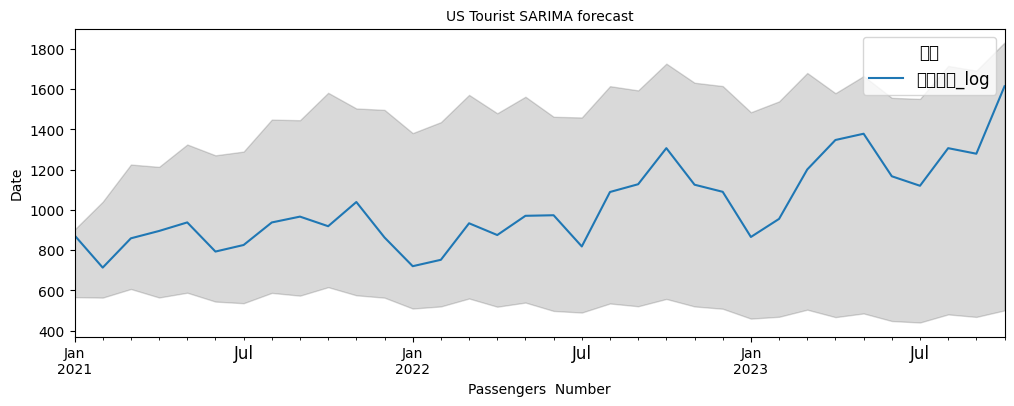

/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
<ipython-input-6-76340938a3df>:191: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)


,Stationarity_adf,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag20),Autocorr(lag30),Heteroscedasticity
Statistics,-5.695,0.858,1.116,4.133,29.971,55.466,12.89126
p_value,0.000,0.000,0.291,0.530,0.070,0.003,0.0
Critical Value(1%),-3.449,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,4210.565,NaN,NaN,NaN,NaN,NaN,NaN
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,two-sided


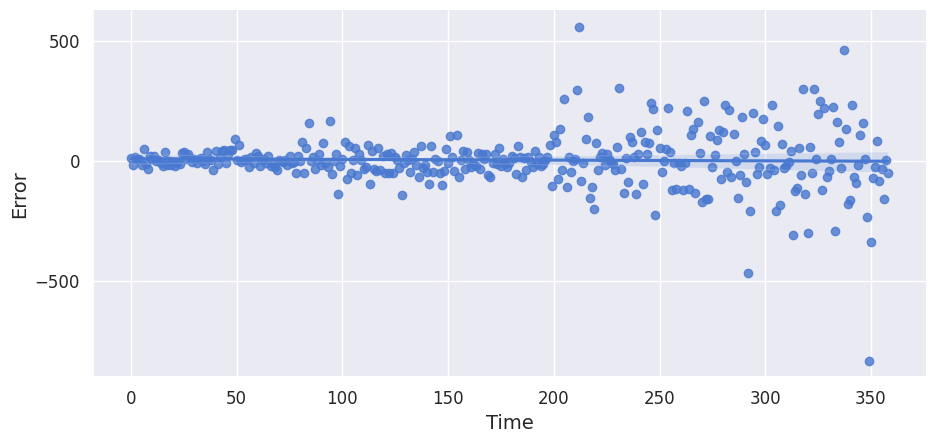

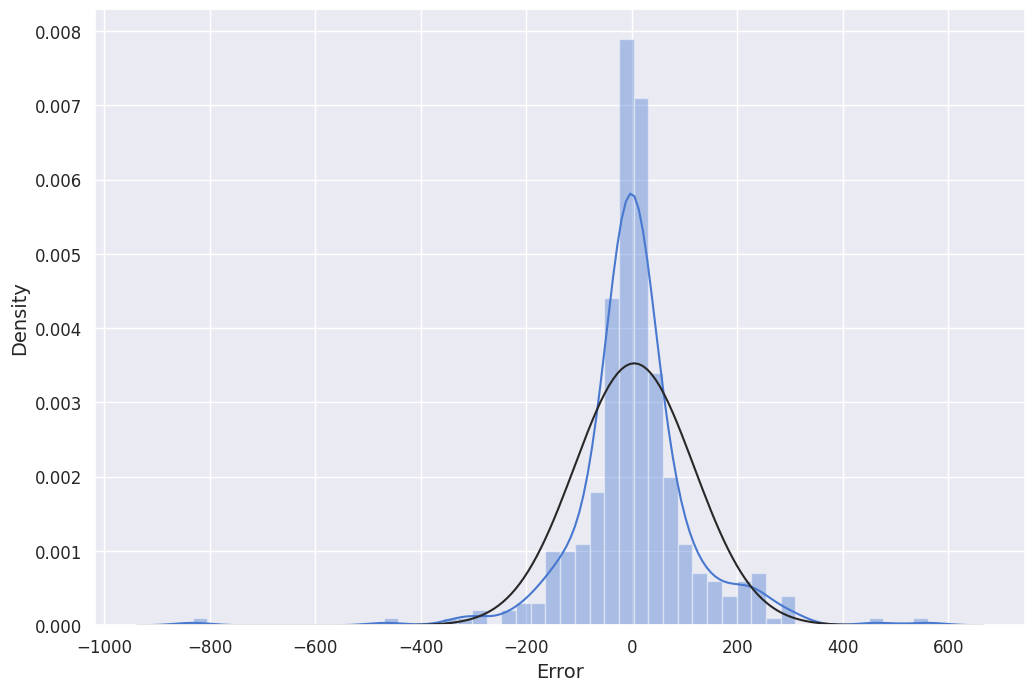

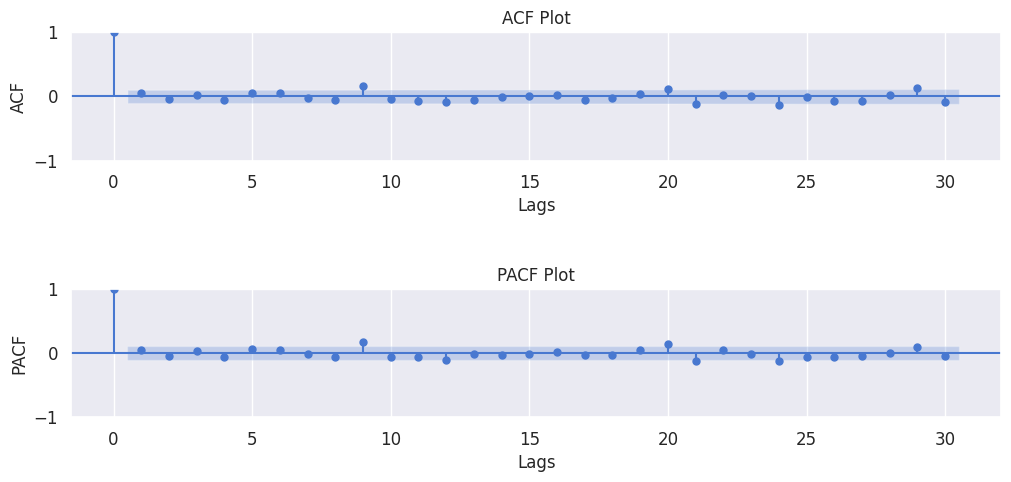

In [ ]:
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_re, pred_tr_sarimax,
                                                                             Y_test_re, pred_te_sarimax, graph_on=True)
display(Score_ts_sarimax)

ax = pd.DataFrame(Y_test_re).plot(figsize=(12,4))

ax.fill_between(pd.DataFrame(pred_te_sarimax_ci, index=Y_test.index).index,
                pd.DataFrame(pred_te_sarimax_ci, index=Y_test.index).iloc[:,0],
                pd.DataFrame(pred_te_sarimax_ci, index=Y_test.index).iloc[:,1], color='k', alpha=0.15)


# Title 설정
ax.set_title("US Tourist SARIMA forecast", fontsize=10)
# x축 레이블 설정
ax.set_xlabel("Passengers  Number", fontsize=10)
# y축 레이블 설정
ax.set_ylabel("Date", fontsize=10)

# x축 눈금 값 설정
plt.xticks(fontsize=10)
# y축 눈금 값 설정
plt.yticks(fontsize=10)

plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train, graph_on=True)

In [ ]:
Y_train = target_df

seasonal_order = 12

## SARIMAX
logarithm, differencing = True, False

fit_ts_sarimax = sm.tsa.SARIMAX(Y_train, order=(1,1,1), seasonal_order=(1,1,1,seasonal_order), trend='c').fit()
display(fit_ts_sarimax.summary())
pred_train_sarimax = fit_ts_sarimax.predict()
pred_test_sarimax = fit_ts_sarimax.get_forecast(len(Y_test)).predicted_mean
pred_test_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test)).conf_int()

# ## 비정상성으로 변환
if logarithm:
    Y_train_re = np.exp(Y_train).copy()
    Y_test_re = np.exp(Y_test).copy()
    pred_tr_sarimax = np.exp(pred_train_sarimax).copy()
    pred_te_sarimax = np.exp(pred_test_sarimax).copy()
    pred_te_sarimax_ci = np.exp(pred_test_sarimax_ci).copy()

if differencing:
    pred_tr_sarimax = np.cumsum(pred_train_sarimax).copy()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           여행수입_log   No. Observations:                  405
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 255.815
Date:                            Tue, 28 Nov 2023   AIC                           -499.631
Time:                                    17:03:01   BIC                           -475.803
Sample:                                01-31-1990   HQIC                          -490.187
                                     - 09-30-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.301e-05   3.34e-05     -0.688      0.491   -8.85e-05    4.25e-05
ar.L1          0.9039      0.031     28.696      0.000       0.842       0.966
ma.L1         -0.9855      0.020    -49.783      0.000      -1.024      -0.947
ar.S.L12      -0.0010      0.076     -0.014      0.989      -0.149       0.147
ma.S.L12      -0.7553      0.070    -10.862      0.000      -0.892      -0.619
sigma2         0.0154      0.001     18.544      0.000       0.014       0.017
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):               265.54
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# 12개월 이후를 예측하기 위한 날짜 범위 생성
forecast_period = 12
forecast_index = pd.date_range(start=Y_train.index[-1], periods=forecast_period + 1, freq='M')[1:]

# # SARIMAX 모형을 사용하여 예측 수행
forecast_result = fit_ts_sarimax.get_forecast(steps=forecast_period)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# 예측 결과 출력
print("Forecast Mean:")
print(forecast_mean)

print("\nForecast Confidence Intervals:")
print(forecast_ci)

Forecast Mean:
2023-10-31    7.191897
2023-11-30    7.134501
2023-12-31    7.086653
2024-01-31    6.985309
2024-02-29    6.977071
2024-03-31    7.087709
2024-04-30    7.049159
2024-05-31    7.082610
2024-06-30    6.983222
2024-07-31    6.952470
2024-08-31    7.103552
2024-09-30    7.092528
Freq: M, Name: predicted_mean, dtype: float64

Forecast Confidence Intervals:
            lower 여행수입_log  upper 여행수입_log
2023-10-31        6.948890        7.434903
2023-11-30        6.804558        7.464444
2023-12-31        6.698072        7.475234
2024-01-31        6.553173        7.417444
2024-02-29        6.511060        7.443081
2024-03-31        6.594607        7.580810
2024-04-30        6.533970        7.564348
2024-05-31        6.549149        7.616070
2024-06-30        6.434467        7.531976
2024-07-31        6.390787        7.514153
2024-08-31        6.530844        7.676260
2024-09-30        6.510343        7.674713


In [ ]:
predicted_df = pd.concat([forecast_mean, forecast_ci], axis=1)

In [ ]:
predicted_df = np.exp(predicted_df)

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing

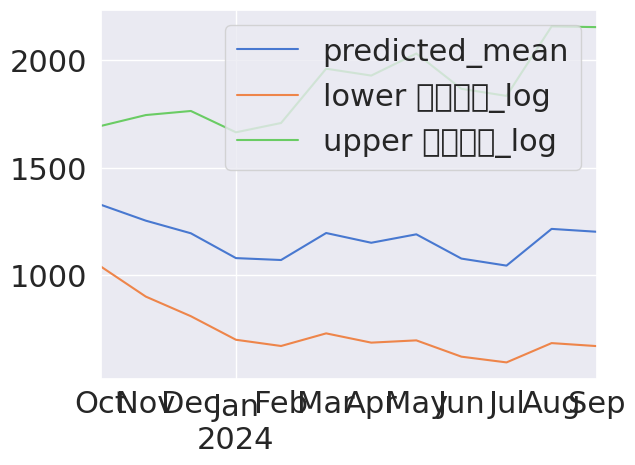

In [ ]:
predicted_df.plot()

In [ ]:
from datetime import datetime

date_info = datetime.today().strftime(format="%Y-%m-%d")

## 학습한 W2V 모델 저장
fit_ts_sarimax.save(f'/content/drive/MyDrive/Smart_Data_Analysis_Class_202302_비공개/Week_13/ts_model/ts_model_{date_info}.pkl')

In [ ]:
# import pickle
# import pandas as pd

# # 저장된 모형 불러오기
# loaded_model = pickle.load(open('/content/drive/MyDrive/Smart_Data_Analysis_Class_202302_비공개/Week_13/ts_model/ts_model_{date_info}.pkl', 'rb'))

# # 12개월 이후를 예측하기 위한 날짜 범위 생성
# forecast_period = 12
# forecast_index = pd.date_range(start=Y_test.index[-1], periods=forecast_period + 1, freq='M')[1:]

# # SARIMAX 모형을 사용하여 예측 수행
# forecast_result = loaded_model.get_forecast(steps=forecast_period)
# forecast_mean = forecast_result.predicted_mean
# forecast_ci = forecast_result.conf_int()

# # 예측 결과 출력
# print("Forecast Mean:")
# print(forecast_mean)

# print("\nForecast Confidence Intervals:")
# print(forecast_ci)